In [277]:
import pickle
import glob
from pathlib import Path

from pyprojroot.here import here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches

In [162]:
def augment_parameters_df_with_prod_averages(df_parameters, df_trajectories): 
    df2 = df_parameters.copy()
    
    for i, row in df2.iterrows():
        start = row.cutoff_start
        end = row.cutoff_end

        career_stage = df_trajectories[
            (df_trajectories.CareerAgeZero >= start) &
            (df_trajectories.CareerAgeZero < end) # excludes end to match what happens in fit/src/lib_fit_models.py
        ]
        df2.loc[i, 'avg_q_adj_delta'] = career_stage.q_adj_delta.mean()
        df2.loc[i, 'avg_pubs_adj'] = career_stage.pubs_adj.mean()


        # Cluster robust standard errors
        n_people = career_stage["PersonId"].nunique()
        df2.loc[i, 'se_q_adj_delta'] = career_stage.groupby("PersonId")["q_adj_delta"].mean().std(ddof=1) / np.sqrt(n_people)
        df2.loc[i, 'se_pubs_adj'] = career_stage.groupby("PersonId")["pubs_adj"].mean().std(ddof=1) / np.sqrt(n_people)


    df2['last_stage'] = False
    df2.loc[i, 'last_stage'] = True
    df2['nth_stage'] = range(len(df2))
    df2['nth_from_last_stage'] = range(len(df2) - 1, -1, -1)
    
    return df2

In [297]:
fields_to_display_names = {
    "biological_sciences": "Biological\nSciences",
    "sociology": "Sociology",
    "management": "Management",
    "mathematics": "Mathematics",
    "computer_science": "CS (AARC)",
    "economics": "Economics",
    "electrical_engineering": "Electrical\nEngineering",
    "chemistry": "Chemistry",
    "psychology": "Psychology",
    "mechanical_engineering": "Mechanical\nEngineering",
    "political_science": "Political Science",
    "history": "History",
    "physics": "Physics",
}

In [364]:
#######################################
# Import data
#######################################

# Empirical trajectories
df_traj_all = pd.read_csv(here("input/import/all-trajectories.csv"))

# Fitted results fits
with open(here("input/fit/results-all-trajectories.pickle"), "rb") as f:
    results_dblp = pickle.load(f)

# AARC trajectories
aarc = {}

for path in Path(here("input/import/")).glob("aarc_trajectories_*.csv"):
    field = path.stem.partition("_")[2].partition("_")[2]

    print(f"Loading {field}...")

    result_path = here(f"input/fit/results-{path.stem}.pickle")
    with open(result_path, "rb") as f:
        result = pickle.load(f)

    df_trajectories_field = pd.read_csv(path)
    mle_cutoffs = result['df_reg_scores'].sort_values(by='aic_varying').cutoffs.iloc[0]
    mle_cutoff_parameters = result['regression_for_cutoffs'][mle_cutoffs]
    df_parameters = pd.DataFrame(mle_cutoff_parameters)
    df_parameters['field'] = field
    df_parameters['display_field'] = fields_to_display_names[field]

    df_parameters = augment_parameters_df_with_prod_averages(df_parameters, df_trajectories_field)
    
    aarc[field] = {
        'trajectories': df_trajectories_field,
        'results': result,
        'mle_cutoffs': mle_cutoffs,
        'mle_cutoff_parameters': df_parameters,
        'display_field': fields_to_display_names[field],
    }

Loading biological_sciences...
Loading sociology...
Loading physics...
Loading management...
Loading mathematics...
Loading computer_science...
Loading economics...
Loading electrical_engineering...
Loading chemistry...
Loading psychology...
Loading mechanical_engineering...
Loading political_science...
Loading history...


In [365]:
mle_cutoffs_dblp = results_dblp['df_reg_scores'].sort_values(by='aic_varying').cutoffs.iloc[0]
mle_cutoff_parameters_dblp = results_dblp['regression_for_cutoffs'][mle_cutoffs_dblp]

df_parameters_dblp = pd.DataFrame(mle_cutoff_parameters_dblp)
df_parameters_dblp['field'] = 'cs_dblp'
df_parameters_dblp['display_field'] = 'CS (dblp)'
df_parameters_dblp = augment_parameters_df_with_prod_averages(df_parameters_dblp, df_traj_all.rename(columns={'dblp': 'PersonId'}))

df_parameters_dblp

,cutoffs,cutoff_start,cutoff_end,alpha,mode_beta,mode_mu,nll_mode,nll_mode_fixed,n,field,display_field,avg_q_adj_delta,avg_pubs_adj,se_q_adj_delta,se_pubs_adj,last_stage,nth_stage,nth_from_last_stage
0,"(4, 7, 13)",0,4.0,4.454494,0.805997,-0.372357,22029.397235,22155.408981,8015,cs_dblp,CS (dblp),0.831385,6.265200,0.035469,0.103758,False,0,3
1,"(4, 7, 13)",4,7.0,4.252503,0.725397,0.070498,15397.188832,15410.774408,5625,cs_dblp,CS (dblp),-0.457994,7.665273,0.045678,0.129295,False,1,2
2,"(4, 7, 13)",7,13.0,3.780789,0.726605,-0.625005,23254.155656,23278.874268,8923,cs_dblp,CS (dblp),-0.289809,6.692728,0.032422,0.130856,False,2,1
3,"(4, 7, 13)",13,inf,3.520843,0.754282,-0.020581,15123.923068,15165.220071,5965,cs_dblp,CS (dblp),-0.204647,6.353305,0.046661,0.170607,True,3,0


In [366]:
for field in aarc.keys():
    print(f"MLE cutoffs for {field}: {aarc[field]['mle_cutoffs']}")

MLE cutoffs for biological_sciences: (1, 7)
MLE cutoffs for sociology: (1, 7, 9)
MLE cutoffs for physics: (4, 8, 10)
MLE cutoffs for management: (1, 3, 8)
MLE cutoffs for mathematics: (3, 7)
MLE cutoffs for computer_science: (2, 5, 9)
MLE cutoffs for economics: (1, 2, 6)
MLE cutoffs for electrical_engineering: (1, 2, 7)
MLE cutoffs for chemistry: (1, 3, 6)
MLE cutoffs for psychology: (2, 6, 7)
MLE cutoffs for mechanical_engineering: (1, 3, 6)
MLE cutoffs for political_science: (1, 6)
MLE cutoffs for history: (6, 8, 10)


In [367]:
df_all_fields_params = pd.concat([field['mle_cutoff_parameters'] for field in aarc.values()])
print(df_all_fields_params.shape)

df_all_fields_params.head()

(49, 18)


,cutoffs,cutoff_start,cutoff_end,alpha,mode_beta,mode_mu,nll_mode,nll_mode_fixed,n,field,display_field,avg_q_adj_delta,avg_pubs_adj,se_q_adj_delta,se_pubs_adj,last_stage,nth_stage,nth_from_last_stage
0,"(1, 7)",0,1.0,1.843758,0.600000,-0.08,4264.747113,4264.747113,2391,biological_sciences,Biological\nSciences,0.070682,2.298202,0.045639,0.054630,False,0,2
1,"(1, 7)",1,7.0,1.945976,0.666667,0.24,18617.089666,18658.380912,9982,biological_sciences,Biological\nSciences,0.079744,2.588660,0.021570,0.059458,False,1,1
2,"(1, 7)",7,inf,1.688694,0.666667,0.04,3709.164246,3724.700613,2122,biological_sciences,Biological\nSciences,-0.178605,2.718662,0.051492,0.105212,True,2,0
0,"(1, 7, 9)",0,1.0,1.557709,0.000000,0.19,1788.143881,1821.376871,1239,sociology,Sociology,0.169492,1.388216,0.050607,0.046230,False,0,3
1,"(1, 7, 9)",1,7.0,1.527719,0.500000,-0.03,8295.505075,8295.505075,5317,sociology,Sociology,0.059620,1.772804,0.025520,0.052922,False,1,2


In [368]:
c1 = "#6CA6C1"
c2 = "#2B2118"

def plot_parameterized_plot(ax, df_params):
    x_var = 'nth_stage'
    ax.scatter(df_params[x_var], df_params.alpha, color=df_params.last_stage.apply(lambda x: c1 if x else c2))

    for (x0, y0), (x1, y1), last_arrow in zip(
        zip(df_params[x_var][:-1], df_params.alpha[:-1]),
        zip(df_params[x_var][1:], df_params.alpha[1:]),
        df_params.last_stage[1:]
    ):
        ax.annotate(
            "", 
            xy=(x1, y1), xycoords="data",
            xytext=(x0, y0), textcoords="data",
            arrowprops=dict(arrowstyle="->", color="gray", lw=3 if last_arrow else 1)
        )

    return ax

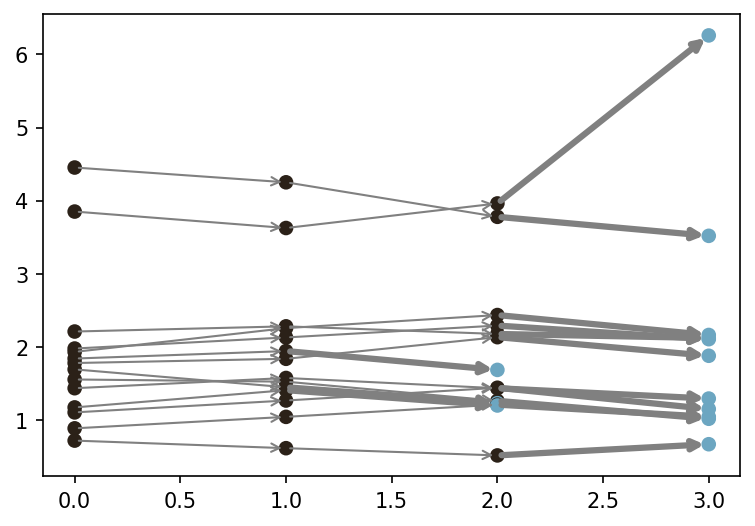

In [211]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)

plot_parameterized_plot(ax, df_parameters_dblp)

for field in aarc.keys():
    plot_parameterized_plot(ax, aarc[field]['mle_cutoff_parameters'])
    

<AxesSubplot: xlabel='alpha', ylabel='Density'>

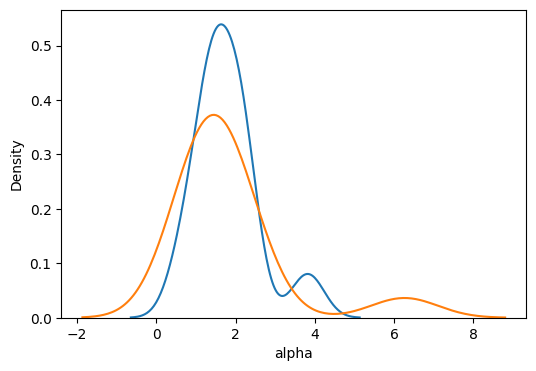

In [212]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sns.kdeplot(df_all_fields_params[df_all_fields_params.last_stage == False].alpha, ax=ax)
sns.kdeplot(df_all_fields_params[df_all_fields_params.last_stage == True].alpha, ax=ax)

In [213]:
df_params = df_parameters_dblp
x_var = 'avg_q_adj_delta'

def compute_delta_for_variable(df_params, x_var = 'alpha'):
    deltas = []
    
    for x0, x1, nth_from_last_stage, in zip(
        df_params[x_var][:-1],
        df_params[x_var][1:],
        df_params.nth_from_last_stage[1:]
    ):
        delta_var = x1 - x0
        deltas.append({
            'delta': delta_var,
            'nth_from_last_stage': nth_from_last_stage,
            'varname': x_var
        })
    
    
    return pd.DataFrame(deltas)

alpha_deltas = df_all_fields_params.groupby('field').apply(compute_delta_for_variable).reset_index()

alpha_deltas.head()

,field,level_1,delta,nth_from_last_stage,varname
0,biological_sciences,0,0.102218,1,alpha
1,biological_sciences,1,-0.257282,0,alpha
2,chemistry,0,0.151445,2,alpha
3,chemistry,1,0.162413,1,alpha
4,chemistry,2,-0.185844,0,alpha


<AxesSubplot: xlabel='delta', ylabel='Density'>

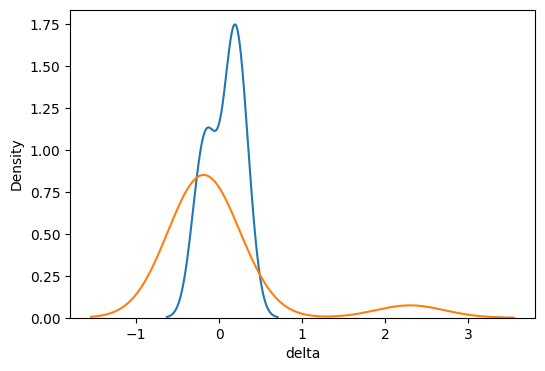

In [214]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sns.kdeplot(alpha_deltas[alpha_deltas.nth_from_last_stage == 1].delta, ax=ax)
sns.kdeplot(alpha_deltas[alpha_deltas.nth_from_last_stage == 0].delta, ax=ax)

<AxesSubplot: xlabel='CareerAgeZero', ylabel='pubs_adj'>

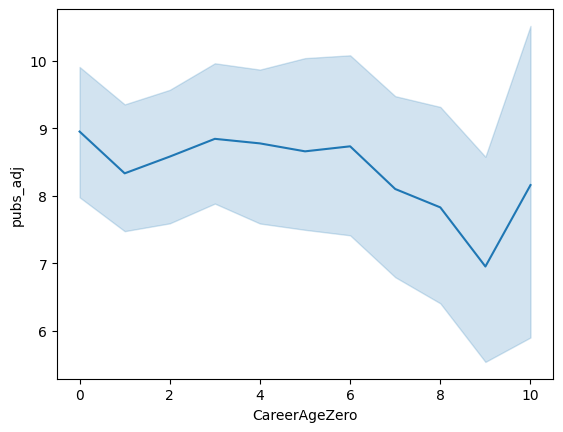

In [216]:
sns.lineplot(data=aarc['physics']['trajectories'], x='CareerAgeZero', y='pubs_adj')

<AxesSubplot: xlabel='CareerAgeZero', ylabel='q_adj_delta'>

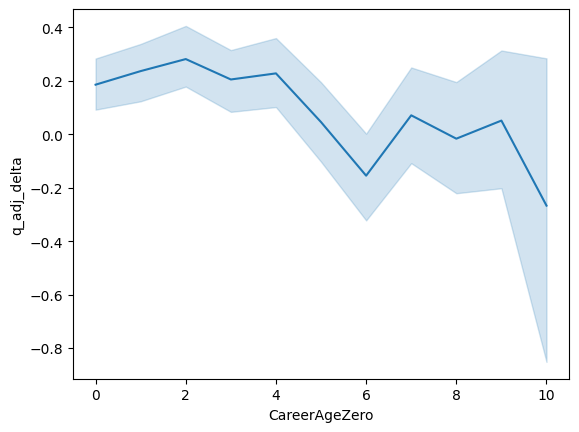

In [217]:
sns.lineplot(data=aarc['psychology']['trajectories'], x='CareerAgeZero', y='q_adj_delta')

<AxesSubplot: xlabel='CareerAgeZero', ylabel='q_adj_delta'>

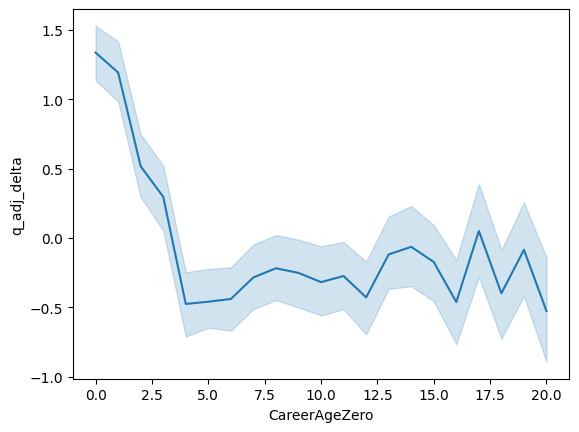

In [218]:
sns.lineplot(data=df_traj_all, x='CareerAgeZero', y='q_adj_delta')

## Figure: does variance drop or shrink between the second-to-last and last stages across fields? $\alpha_{N-1}$ vs. $\alpha_N$

In [369]:
df_second_to_last = df_all_fields_params[df_all_fields_params.nth_from_last_stage == 1]
df_last = df_all_fields_params[df_all_fields_params.nth_from_last_stage == 0]

df_second_to_last.head()

,cutoffs,cutoff_start,cutoff_end,alpha,mode_beta,mode_mu,nll_mode,nll_mode_fixed,n,field,display_field,avg_q_adj_delta,avg_pubs_adj,se_q_adj_delta,se_pubs_adj,last_stage,nth_stage,nth_from_last_stage
1,"(1, 7)",1,7.0,1.945976,0.666667,0.24,18617.089666,18658.380912,9982,biological_sciences,Biological\nSciences,0.079744,2.588660,0.021570,0.059458,False,1,1
2,"(1, 7, 9)",7,9.0,1.265823,0.500000,0.07,1173.431938,1173.431938,853,sociology,Sociology,-0.052755,1.561547,0.056222,0.092019,False,2,1
2,"(4, 8, 10)",8,10.0,3.963604,0.863636,0.88,2116.948558,2123.617285,813,physics,Physics,0.295203,7.466175,0.522543,0.661677,False,2,1
2,"(1, 3, 8)",3,8.0,1.444444,0.000000,-0.01,5256.166330,5256.166330,3843,management,Management,0.018735,1.425709,0.022720,0.040929,False,2,1
1,"(3, 7)",3,7.0,1.451496,0.500000,-0.24,8887.104035,9205.034728,5869,mathematics,Mathematics,-0.027943,1.763674,0.020096,0.042738,False,1,1


In [370]:
parameter_deltas_to_last_stage = df_second_to_last[['alpha', 'mode_mu', 'mode_beta', 'display_field']].rename(columns={
    'alpha': 'alpha_n-1',
    'mode_mu': 'mu_n-1',
    'mode_beta': 'beta_n-1'
}).merge(
    df_last[['alpha', 'mode_mu', 'mode_beta', 'display_field']].rename(columns={
    'alpha': 'alpha_n',
    'mode_mu': 'mu_n',
    'mode_beta': 'beta_n'
}),
    on='display_field'
)

parameter_deltas_to_last_stage['did_variance_drop'] = parameter_deltas_to_last_stage['alpha_n-1'] > parameter_deltas_to_last_stage['alpha_n']
parameter_deltas_to_last_stage['did_mu_drop'] = parameter_deltas_to_last_stage['mu_n-1'] > parameter_deltas_to_last_stage['mu_n']
parameter_deltas_to_last_stage['did_beta_drop'] = parameter_deltas_to_last_stage['beta_n-1'] > parameter_deltas_to_last_stage['beta_n']


parameter_deltas_to_last_stage_no_phys = parameter_deltas_to_last_stage[parameter_deltas_to_last_stage.display_field != 'Physics']

parameter_deltas_to_last_stage_no_phys

,alpha_n-1,mu_n-1,beta_n-1,display_field,alpha_n,mu_n,beta_n,did_variance_drop,did_mu_drop,did_beta_drop
0,1.945976,0.24,0.666667,Biological\nSciences,1.688694,4.000000e-02,0.666667,True,True,True
1,1.265823,0.07,0.500000,Sociology,1.020899,-7.000000e-02,0.500000,True,True,False
3,1.444444,-0.01,0.000000,Management,1.154278,-2.000000e-02,0.000000,True,True,False
4,1.451496,-0.24,0.500000,Mathematics,1.234111,8.881784e-16,0.500000,True,False,True
5,1.437943,-0.44,0.500000,CS (AARC),1.296844,-5.000000e-02,0.666667,True,False,False
6,1.213851,0.14,0.000000,Economics,1.048239,-2.000000e-02,0.000000,True,True,False
7,2.136076,0.34,0.666667,Electrical\nEngineering,1.881782,-1.500000e-01,0.714286,True,True,False
8,2.294549,0.04,0.800000,Chemistry,2.108705,-7.000000e-02,0.750000,True,True,True
9,2.179819,-0.02,0.750000,Psychology,2.124781,-3.800000e-01,0.800000,True,True,False
10,2.438220,0.30,0.785714,Mechanical\nEngineering,2.165975,-4.000000e-02,0.750000,True,True,True


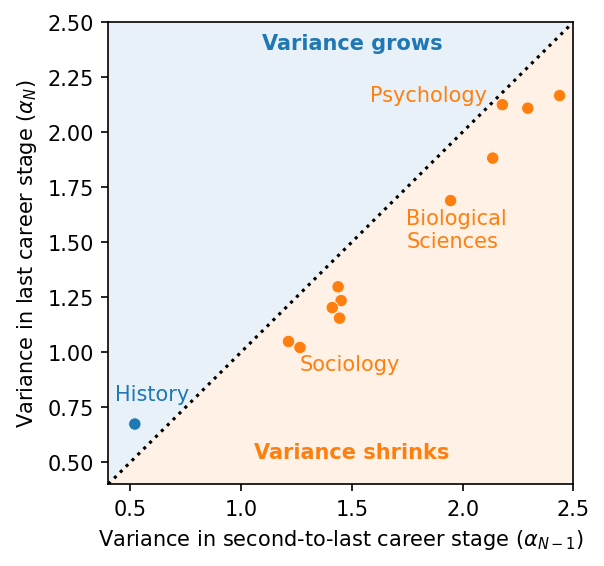

In [337]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi =150)

sns.scatterplot(data=parameter_deltas_to_last_stage_no_phys, x='alpha_n-1', y='alpha_n', hue='did_variance_drop', ax=ax, legend=False)

#ax.scatter(df_parameters_dblp[df_parameters_dblp.nth_from_last_stage == 1].alpha, df_parameters_dblp[df_parameters_dblp.nth_from_last_stage == 0].alpha, color=sns.color_palette()[1])

ax.plot([0.4, 2.5], [0.4, 2.5], color='black', linestyle=':')
ax.margins(0)
ax.set_xlabel(r"Variance in second-to-last career stage ($\alpha_{N-1}$)")
ax.set_ylabel(r"Variance in last career stage ($\alpha_N$)")
ax.text(
    1.5, 2.45, "Variance grows",
    ha='center', va='top',
    color=sns.color_palette()[0],
    fontweight='bold',
)
ax.text(
    1.5, 0.5, "Variance shrinks",
    ha='center', va='bottom',
    color=sns.color_palette()[1],
    fontweight='bold',
)

top_triangle = patches.Polygon(
    [[0.4, 0.4], [0.4, 2.5], [2.5, 2.5]],
    closed=True,
    facecolor=sns.color_palette()[0],
    alpha=0.1,
    edgecolor=None
)
ax.add_patch(top_triangle)

bottom_triangle = patches.Polygon(
    [[0.4, 0.4], [2.5, 0.4], [2.5, 2.5]],
    closed=True,
    facecolor=sns.color_palette()[1],
    alpha=0.1,
    edgecolor=None
)
ax.add_patch(bottom_triangle)

fields_to_show = ['History', 'Biological\nSciences', 'Sociology', 'Psychology']

offsets_x = {
    'History': -0.09,
    'Biological\nSciences': -0.2,
    'Psychology': -0.6
}

offsets_y = {
    'History': 0.09,
    'Biological\nSciences': -0.23,
    'Sociology': -0.12
}

for _, row in parameter_deltas_to_last_stage_no_phys.iterrows():
    if row.display_field not in fields_to_show:
        continue
        
    ax.text(
        row["alpha_n-1"]+offsets_x.get(row.display_field, 0),
        row["alpha_n"]+offsets_y.get(row.display_field, 0),
        row["display_field"],
        fontsize=10,
        c=sns.color_palette()[1] if row.did_variance_drop else sns.color_palette()[0],
        ha="left",
        va="bottom"
    )

#ax.text(0.5, 2.55, "A.", fontsize=17)


#ax = axes[1]

#sns.scatterplot(data=parameter_deltas_to_last_stage_no_phys, x='beta_n-1', y='beta_n', hue='did_beta_drop', ax=ax, legend=False)

#ax.set_xlabel(r"$\beta_{n-1}$")
#ax.set_ylabel(r"$\beta_n$")


#sns.despine()
#plt.tight_layout()

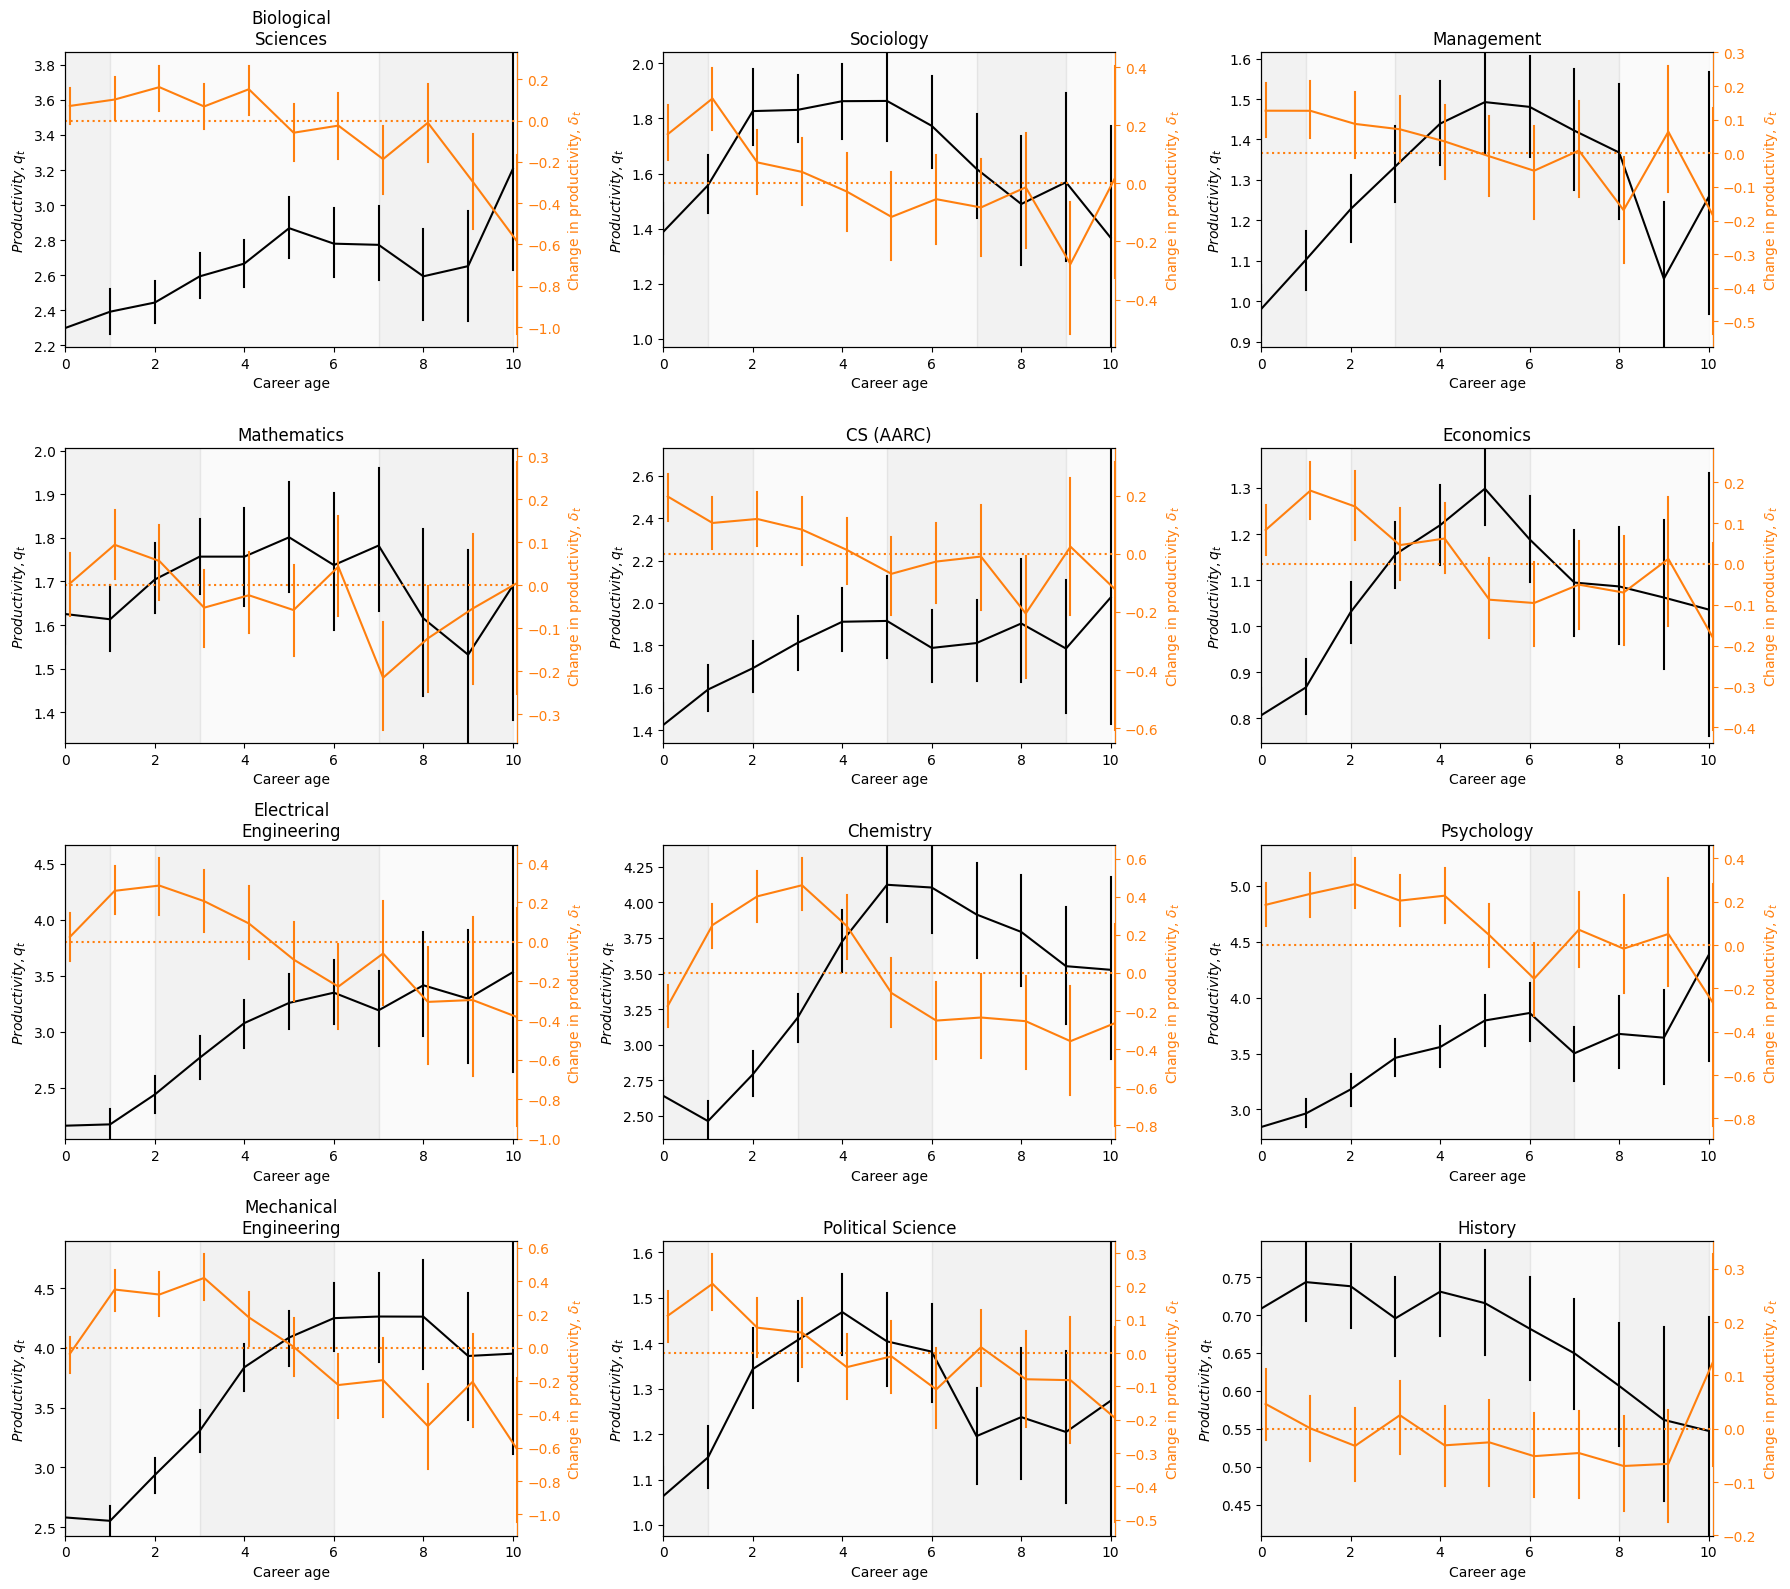

In [395]:
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()

for field, ax in zip(fields_to_display_names.keys(), axes):
    df_field = aarc[field]['trajectories'].copy()

    df_field['CareerAgeZeroShifted'] = df_field['CareerAgeZero'] + 0.1
    cutoffs = aarc[field]['mle_cutoffs']

    sns.lineplot(data=df_field, x='CareerAgeZero', y='pubs_adj', ax=ax, color='black', err_style='bars') #err_kws={'alpha': 0.05})
    
    ax.margins(0)

    ax.set_ylabel(r"$Productivity, q_t$")
    
    ax.set_xlabel("Career age")
    ax.set_title(aarc[field]['display_field'])
    
    for i, (start, end) in enumerate(zip((0,) + cutoffs, cutoffs + (10,))):
        ax.axvspan(start, end, alpha=0.1, color='gray' if i%2 == 0 else 'lightgray')

    # Twin axis
    
    ax2 = ax.twinx()
    sns.lineplot(data=df_field, x='CareerAgeZeroShifted', y='q_adj_delta', ax=ax2, color=sns.color_palette()[1], err_style='bars') #err_kws={'alpha': 0.05})
    ax2.axhline(0, color=sns.color_palette()[1], linestyle=':')
    ax2.set_ylabel(r"Change in productivity, $\delta_t$", color=sns.color_palette()[1])
    ax2.tick_params(axis="y", colors=sns.color_palette()[1])
    ax2.spines["right"].set_color(sns.color_palette()[1])

    
plt.tight_layout()